In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv('datasets/df.csv')
df['Date_Time_Event_Began'] = pd.to_datetime(df['Date_Time_Event_Began'],errors='coerce')
df['Date_Time_Restoration'] = pd.to_datetime(df['Date_Time_Restoration'],errors='coerce')
df.head()


,Month,Area_Affected,Event_Type,Demand_Loss_(MW),Number_of_Customers_Affected,Date_Time_Event_Began,Date_Time_Restoration,Event_Duration_(hours),Year
0,January,Washington,System Operations,0.0,NaN,2019-01-05 13:19:00,2019-01-05 15:07:00,1.80,2019
1,January,Washington,Severe Weather,230.0,230000.0,2019-01-06 03:00:00,2019-01-09 07:00:00,76.00,2019
2,January,California,Severe Weather,300.0,90382.0,2019-01-06 17:56:00,2019-01-06 21:52:00,3.93,2019
3,January,Washington,Severe Weather,NaN,230000.0,2019-01-06 01:00:00,2019-01-06 12:00:00,11.00,2019
4,January,Michigan,System Operations,0.0,0.0,2019-01-07 20:57:00,2019-01-07 21:32:00,0.58,2019


### Initial Analysis

In [8]:
# basic statistics
df[['Demand_Loss_(MW)','Number_of_Customers_Affected','Event_Duration_(hours)']].describe()

,Demand_Loss_(MW),Number_of_Customers_Affected,Event_Duration_(hours)
count,1028.000000,1.250000e+03,1242.000000
mean,418.759728,5.614533e+04,16.320089
std,4430.331371,1.646479e+05,33.330040
min,0.000000,0.000000e+00,0.020000
25%,0.000000,0.000000e+00,0.670000
50%,0.000000,0.000000e+00,3.090000
75%,32.500000,5.884475e+04,14.870000
max,133200.000000,2.000000e+06,328.920000


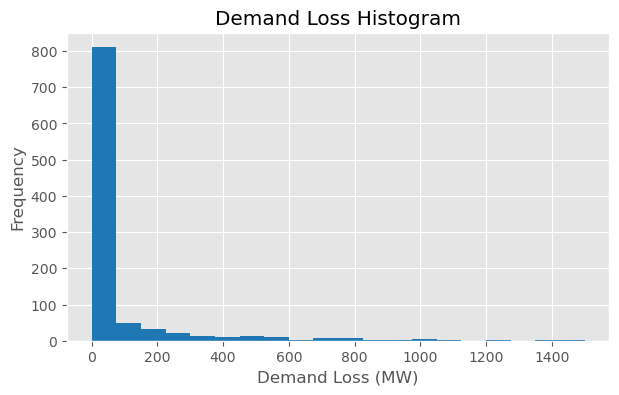

In [5]:
ax = df.loc[df['Demand_Loss_(MW)']<=1500,'Demand_Loss_(MW)'].plot(kind='hist',
                            bins=20,
                            figsize=(7,4),
                            color='tab:blue',
                            title='Demand Loss Histogram')
ax.set_xlabel('Demand Loss (MW)')
plt.show()

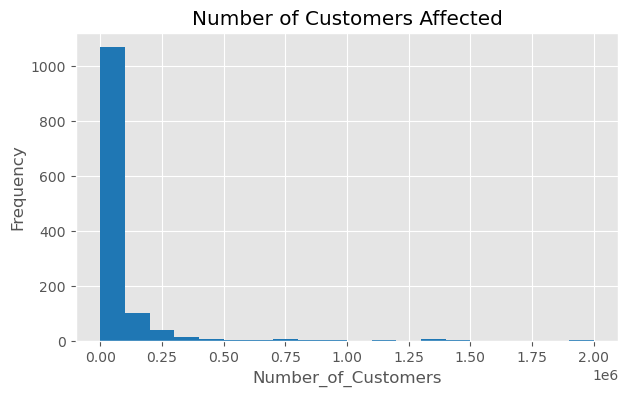

In [6]:
ax = df['Number_of_Customers_Affected'].plot(kind='hist',
                                             bins=20,
                                             color='tab:blue',
                                             title='Number of Customers Affected',
                                             figsize=(7,4))
ax.set_xlabel('Number_of_Customers')
plt.show()

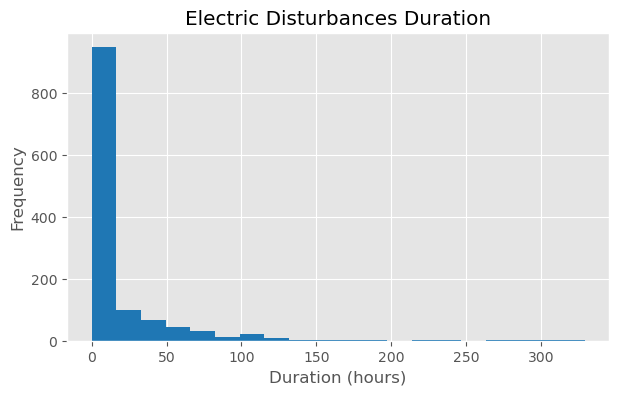

In [7]:
ax = df['Event_Duration_(hours)'].plot(kind='hist',
                                       figsize=(7,4),
                                       color='tab:blue',
                                       bins=20,
                                       title='Electric Disturbances Duration')
ax.set_xlabel('Duration (hours)')
plt.show()

Insigths:
 1. Half of the values in Demand Loss and Number of Customers Affected are zero.
 2. Over the past four years, an average of approximately 56,000 customers have experienced an electrical disturbance.
 3. Half of the electric disturbances last less than 3 hours.
 4. 25% of electric disturbances in the last four years have lasted more than 14 hours.  

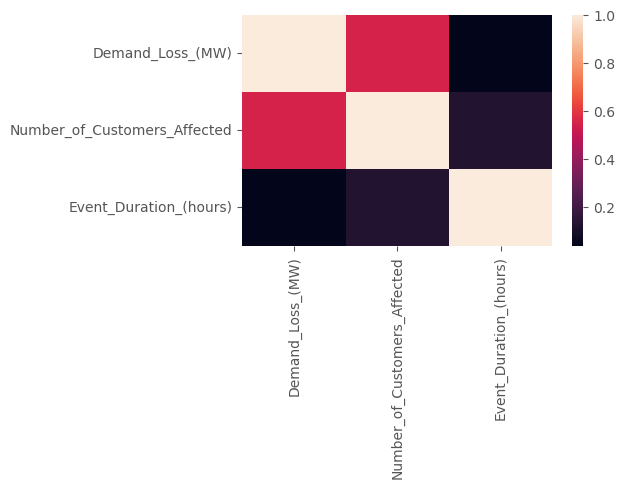

In [8]:
df_corr = df[['Demand_Loss_(MW)','Number_of_Customers_Affected','Event_Duration_(hours)']].dropna().corr()

fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(df_corr)
plt.show()

## Questions

### How many electric disturbances occurred in the U.S. from 2019 to 2022?

In [12]:
print(f'{df.shape[0]} events were recorded.')

1438 events were recorded.


### What is the number of events per year?

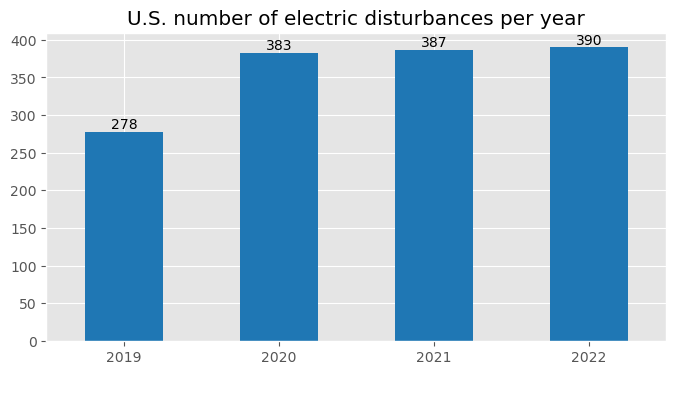

In [78]:
#fig, ax = plt.subplots(figsize=(5,3))

ax = df.groupby('Year')['Area_Affected'] \
      .agg('count')\
      .plot(kind='bar',
            title='U.S. number of electric disturbances per year',
            rot=0,
            color='tab:blue',
            figsize=(8,4))

ax.set_xlabel(' ')
ax.bar_label(ax.containers[0])
plt.show()

- In the last three years the number of electric disturbances are quite close.
- It is important to remember that in 2020 and 2021 occurred severe blackouts, which did not happen in 2022.

#


### What is the number of electric disturbances by month each year?

In [73]:
#aggregating the number of events by year and month
df_plotly = df.groupby(['Year','Month'], sort=False, as_index=False)['Area_Affected'] \
                .agg('count') \
                .rename(columns={'Area_Affected':'Number_of_Events'})

#creating a new column concatenating months and years
df_plotly['Month_Year'] = df_plotly['Month'] \
                              +' '+df_plotly['Year'].apply(str)
#ploting
fig = px.line(df_plotly, 
              x='Month_Year', 
              y='Number_of_Events',
              title='U.S. monthly number of electric disturbances: 2019-2022',
              labels={
                     'Number_of_Events': 'Number of Events ',
                     'Month_Year': ' '
                        },
              markers=True          
            )

#setting the x tick labels
fig.update_xaxes(ticktext=['Jan 2019','Jan 2020','Jan 2021','Jan 2022'],
                 tickvals=['January 2019','January 2020','January 2021','January 2022'],)
fig.show()                          


- The two largest numbers of events (August 2020 and February 2021) were caused by blackouts in California and Texas, respectively.
- In 2021 and 2022, the number of disturbances increases as summer approaches and tends to decrease in the fall.



# 

### What is the number of disturbances by season each year?

In [72]:
#Spring - March to May.
#Summer - June to August.
#Autumn - September to November.
#Winter - December to February.

#creating a temporary dataframe
df_temp_season = df.copy()

# categorizing every month according to its season
cat_mapping = {
    'March':'Spring',
    'April':'Spring',
    'May':'Spring',
    'June':'Summer',
    'July':'Summer',
    'August':'Summer',
    'September':'Fall',
    'October':'Fall',
    'November':'Fall',
    'December':'Winter',
    'January':'Winter',
    'February':'Winter'
}

# creting a column 'Season'
df_temp_season['Season'] = df_temp_season['Month'].map(cat_mapping)

# grouping by year/season and counting the number of events using the 'Area_Affected' column
df_temp_season = df_temp_season.groupby(['Year','Season'], as_index=False)['Area_Affected'] \
                               .agg('count')

# stacked bar plot 
fig = px.bar(df_temp_season,
             x='Year',
             y='Area_Affected',
             color='Season',
             title='U.S. number of electric disturbances by season',
             width=700,
             height=500,
             labels={
                 'Year' : ' ',
                 'Area_Affected': 'Number of events'}
             )
fig.show()


- In the last four years, summer season had more disturbances in three years.
- From 2019 to 2022, the number of electric disturbances in the fall season are similar.  

In [ ]:
# https://realpython.com/pandas-groupby/
# https://seaborn.pydata.org/generated/seaborn.lineplot.html
# https://www.datacamp.com/tutorial/python-seaborn-line-plot-tutorial


### What is the number of events by U.S. state?

In [3]:
# list with all the US states
us_states_list = ['Alabama','Alaska', 'Arizona', 'Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']

# list with US states abbreviation
us_stat_abbr_list = ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI','MN','MS','MO',
'MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VT','VA','WA','WV','WI','WY']

cat_mapping = {us_states_list[i] : us_stat_abbr_list[i] for i in range(len(us_states_list))}

# list with the number of events 
num_events_by_state = [sum(df['Area_Affected'].str.contains(i)) for i in us_states_list]

# ploting the US map with the number of electric disturbances by state
fig = px.choropleth(locations=us_stat_abbr_list,
                    locationmode='USA-states',
                    color=num_events_by_state,
                    labels={'color': 'Number of events'},
                    color_continuous_scale='Blues',
                    scope='usa',
                    height=400,
                    width=700)
fig.update_layout(
    margin={"r":0,"t":50,"l":0,"b":0},
    title_text = '2019-2022 U.S number of electric disturbances by state')
fig.show()

### Which states registered more disturbance events from 2019-2022?

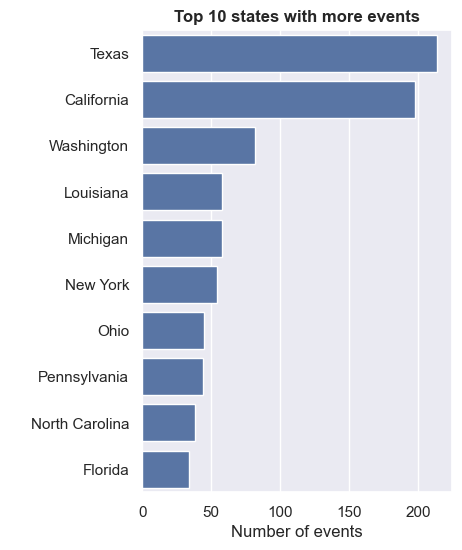

In [19]:
# dataframe with the number of electric events by US state
df_states_events = pd.DataFrame({'State':us_states_list, 'Number_of_events':num_events_by_state})

df_states_events = df_states_events.sort_values('Number_of_events',ascending=False).head(10)

sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(4,6))

sns.barplot(data=df_states_events,
            x='Number_of_events',
            y='State',
            color='b') \
            .set_title('Top 10 states with more events', 
                       fontdict = {'fontsize':12,
                                   'fontweight':'bold'})

ax.set_ylabel(' ')
ax.set_xlabel('Number of events')
plt.show()


In [ ]:
#https://www.geeksforgeeks.org/choropleth-maps-using-plotly-in-python/
#https://www.geeksforgeeks.org/how-to-make-a-choropleth-map-with-a-slider-using-plotly-in-python/

### Which period of the day experiences the most electric disturbances?

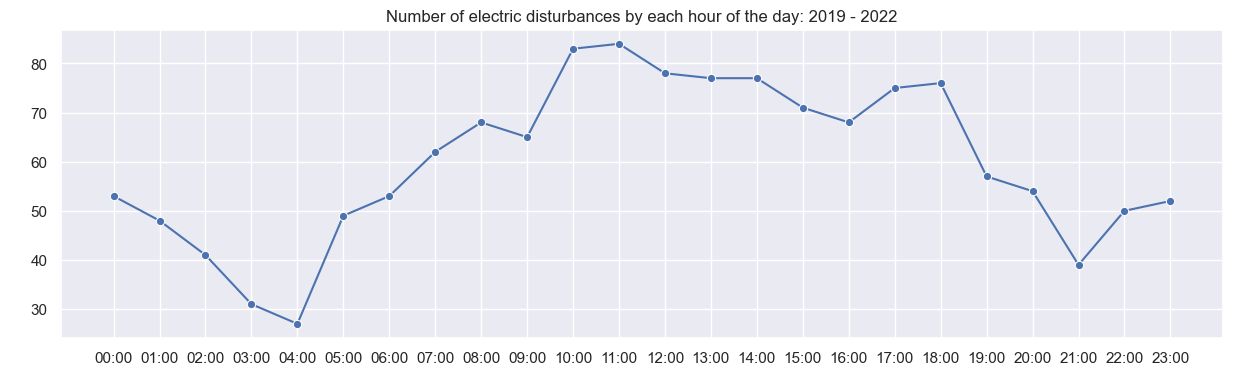

In [18]:
# list with the hour of the day
hour_day = ['00:00','01:00','02:00','03:00','04:00','05:00','06:00','07:00','08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00']
df_events_hour = df.copy()

# adding the 'hour' column to the dataset
df_events_hour['Hour'] = [x.hour for x in df_events_hour['Date_Time_Event_Began']]

# aggregating by hour and counting the number of events 
df_events_hour = df_events_hour.groupby('Hour', as_index=False)['Area_Affected'] \
                                 .agg('count') \
                                 .rename(columns={'Area_Affected':'Number_of_events'})

#plotting
fig, ax = plt.subplots(figsize=(15,4))
sns.set_theme(style='darkgrid')
sns.lineplot(x=hour_day, 
             y=df_events_hour['Number_of_events'],
             marker='o').set(title='Number of electric disturbances by each hour of the day: 2019 - 2022') 
ax.set_ylabel(' ')
plt.show()

- The period of the day with the highest electric disturbances occurs between 11 am and 12 am.

# 

### What are the most common types of events?

In [4]:
# dataframe with all the types of events
total_events_type = events_data['Event Type'].unique()
total_events_type = pd.DataFrame(total_events_type)

# Funtion to search the expression '/'
def str_search(string, expres):
    return expres in str(string)

# searching the '/' in all the lines 
events_type_mask = total_events_type.applymap(lambda x: str_search(x, '/'))

# saving only the unique type of events
unique_events = total_events_type[~events_type_mask].dropna().copy()


events_type_count = [0]*len(unique_events)
events_type_name = list(unique_events.iloc[:,0])

df_events_type = pd.DataFrame({'Event type':events_type_name, 'Number of occurrences':events_type_count})

for i in range(len(events_type_name)):
    event = events_type_name[i]
    df_events_type.loc[i,'Number of occurrences'] = events_data['Event Type'].apply(lambda x: str_search(x, event)).values.sum()   

df_events_type.sort_values('Number of occurrences',ascending=False)    



,Event type,Number of occurrences
1,Severe Weather,504
0,System Operations,295
4,Vandalism,250
5,Transmission Interruption,185
2,Suspicious Activity,138
3,Actual Physical Attack,47
6,Fuel Supply Deficiency,30
12,Cyber Event,19
8,Distribution Interruption,14
7,Generation Inadequacy,7


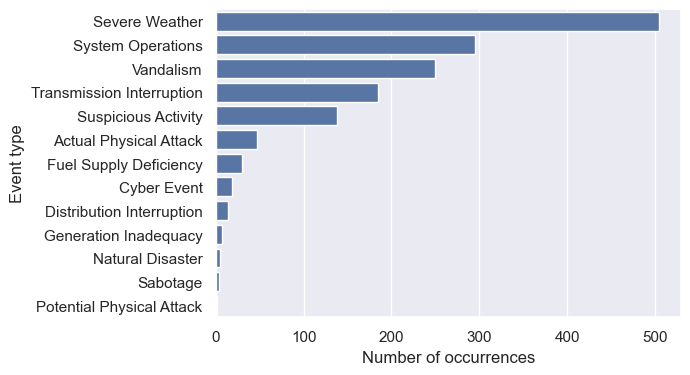

In [10]:
# ploting the results
df_sorted_et = df_events_type.sort_values('Number of occurrences',ascending=False)

sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(figsize = (6,4))

sns.barplot(data=df_sorted_et, x='Number of occurrences', y='Event type', color='b')

plt.show()

### Which event types caused more Demand loss?

In [55]:
# dataframe with all the types of events
total_events_type = events_data['Event Type'].unique()
total_events_type = pd.DataFrame(total_events_type)

def str_search(search, expression):
    return expression in str(search)

events_subset = events_data[['Event Type','Demand Loss (MW)']].dropna().copy()

# searching the '/' in all the lines 
events_type_mask = total_events_type.applymap(lambda x: str_search(x, '/'))

# saving only the unique type of events
unique_events = total_events_type[~events_type_mask].dropna().copy()
events_name = list(unique_events.iloc[:,0])

total_loss_demand = events_subset['Demand Loss (MW)'].sum()
loss_demand = [0]*len(events_name)
percentage = [0]*len(events_name)

for i in range(len(unique_events)):
    mask = events_subset['Event Type'].apply(lambda x: str_search(x,events_name[i]))
    loss_demand[i] = events_subset.loc[mask,'Demand Loss (MW)'].sum() 
    percentage[i] = round((loss_demand[i]*100)/total_loss_demand,2)
    #count
#count['Demand Loss (MW)'].sum()

demand_loss_event_type = pd.DataFrame({'Event Type':events_name, 'Total Demand Loss (MW)':loss_demand, 'Percentage (%)':percentage})
demand_loss_event_type.sort_values('Total Demand Loss (MW)', ascending=False)

,Event Type,Total Demand Loss (MW),Percentage (%)
1,Severe Weather,300071.0,69.71
0,System Operations,72275.0,16.79
5,Transmission Interruption,52318.0,12.15
6,Fuel Supply Deficiency,7983.0,1.85
2,Suspicious Activity,7596.0,1.76
3,Actual Physical Attack,3874.0,0.90
4,Vandalism,3239.0,0.75
7,Generation Inadequacy,2567.0,0.60
8,Distribution Interruption,1526.0,0.35
9,Natural Disaster,654.0,0.15


- Severe weather, system operations and transmission interruptions were responsible for the largest share of lost demand.

(1.0, 100.0)

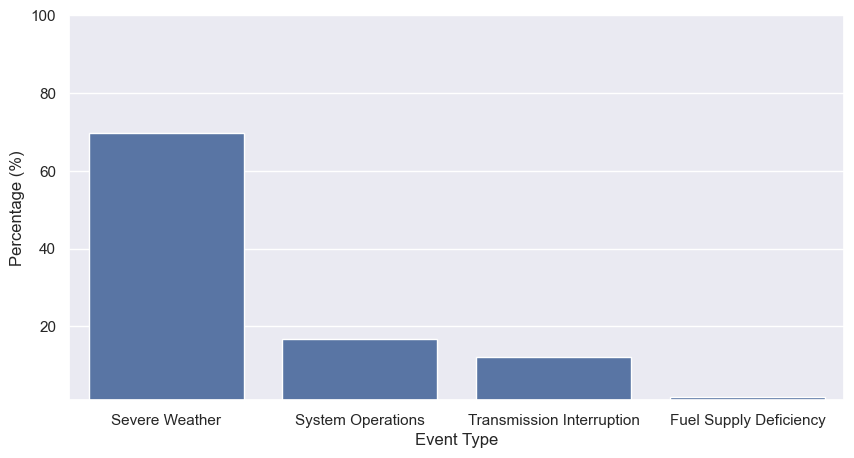

In [74]:
sns.set_theme(style='darkgrid')
fig, ax = plt.subplots(figsize=(10,5))
ax = sns.barplot(data=demand_loss_event_type.sort_values('Total Demand Loss (MW)', ascending=False).head(4),\
            x='Event Type', y='Percentage (%)', color='b')
ax.set_ylim(1,100)

In [ ]:
# read each event type from the column
# read the demand loss of this index 
# sum the values found and add to a variable called 'demand_loss_per_event_type'



### What is the number of customers affected by each year?

C:\Users\Administrador\AppData\Local\Temp\ipykernel_7408\1981161734.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


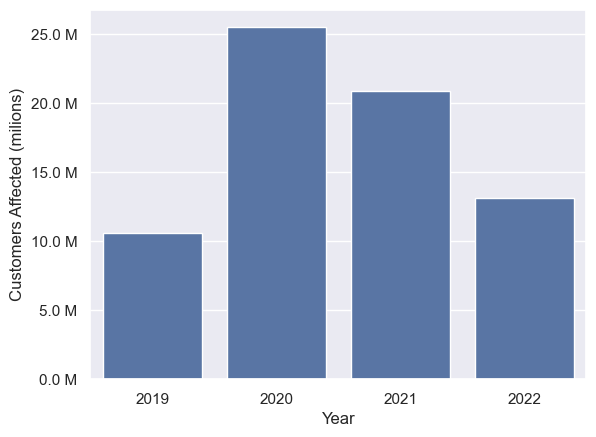

In [107]:
subset_affec_cust = events_data[['Number of Customers Affected','Year']].dropna()
subset_affec_cust = subset_affec_cust.groupby('Year', as_index=False)['Number of Customers Affected'].sum().\
                sort_values('Number of Customers Affected',ascending=False)


sns.set_theme(style='darkgrid')
ax = sns.barplot(data=subset_affec_cust, x='Year', y='Number of Customers Affected', color='b')
ax.set(ylabel='Customers Affected (milions)')
ylabels = ['{:,.1f}'.format(x) + ' M' for x in ax.get_yticks()/(1_000_000)]
ax.set_yticklabels(ylabels)
plt.show()

### What is the average time of restoration by each event type?

In [30]:
type_event_restor = events_data[['Event Type','Event Duration (hours)']].copy()

# dataframe with all the types of events
total_events_type = events_data['Event Type'].unique()
total_events_type = pd.DataFrame(total_events_type)

# Funtion to search the expression '/'
def str_search(string, expres):
    return expres in str(string)

# searching the '/' in all the lines 
events_type_mask = total_events_type.applymap(lambda x: str_search(x, '/'))

# saving only the unique type of events
unique_events = total_events_type[~events_type_mask].dropna().copy()
unique_events = list(unique_events.iloc[:,0])

avg_time_list = []

for i in range(len(unique_events)):
    pattern = unique_events[i]
    mask = type_event_restor['Event Type'].str.contains(pattern)
    avg_time = type_event_restor.loc[mask,'Event Duration (hours)'].mean()
    avg_time_list.append(round(avg_time,2))

df_type_event_restor = pd.DataFrame({'Event_Type':unique_events, 'Avg_Time_Restoration_(hours)':avg_time_list})
df_type_event_restor = df_type_event_restor.sort_values('Avg_Time_Restoration_(hours)', ascending=False)
df_type_event_restor

,Event_Type,Avg_Time_Restoration_(hours)
9,Natural Disaster,12.07
1,Severe Weather,9.23
8,Distribution Interruption,8.63
6,Fuel Supply Deficiency,6.28
12,Cyber Event,5.93
3,Actual Physical Attack,4.56
5,Transmission Interruption,4.56
7,Generation Inadequacy,3.40
0,System Operations,3.14
4,Vandalism,2.89


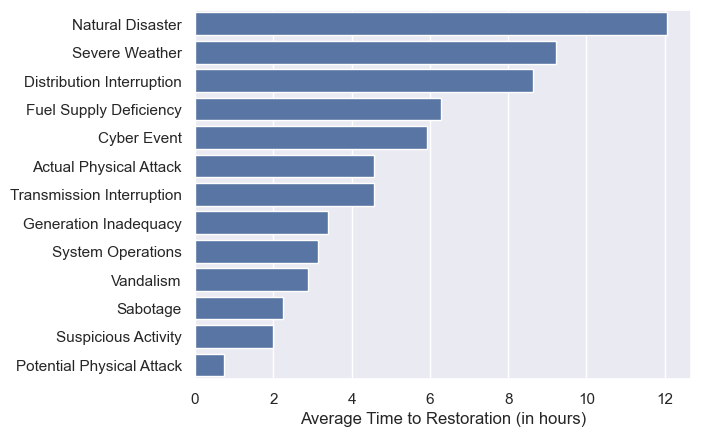

In [35]:
#plt.subplots(figsize=(6,5))
sns.set_theme(style='darkgrid')
ax = sns.barplot(data=df_type_event_restor, x='Avg_Time_Restoration_(hours)', y='Event_Type', color='b')
ax.set(ylabel='',xlabel='Average Time to Restoration (in hours)')
plt.show()
